In [ ]:
###Written by Dylan Steinecke ft. Stack Overflow and the like

In [1]:
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt; import os; from skimage.io import imread, imshow; from skimage.color import rgb2gray; from skimage.morphology import (erosion, dilation, closing, opening, area_closing, area_opening);from skimage.measure import label, regionprops, regionprops_table;import cv2;from matplotlib.backends.backend_pdf import PdfPages;import argparse;from statistics import mean;import json;from IPython.display import Image;from IPython.core.display import display, HTML;display(HTML("<style>.container { width:100% !important; }</style>"))

## Functions

#### Blurs image and performs Canny Edge based on input thresholds

In [41]:
def processImageTest(img, lowerThresh, upperThresh):
    return cv2.Canny(cv2.GaussianBlur(img, (3,3), 0), lowerThresh, upperThresh)

#### Takes an image and returns the count of the connected components (i.e. regions) with sizes, narrowness, and orientations which fit with the specified parameters

In [3]:
##DELETE: I am very confident that this one was an old iteration which I modified, but I'm too scared to delete it, so just ignore it or delete it yourself if you are using it.
def largeNarrowOrientedConnectedComponentCount(img, largeCutoff, narrowCutoff, orientCutoff):
    propertiesDF = pd.DataFrame(regionprops_table(label(img), img, properties = ('major_axis_length', 'minor_axis_length', 'area', 'orientation')));    
    propertiesDF['narrowness'] = propertiesDF['major_axis_length']/propertiesDF['minor_axis_length']; 
    nLO_CCCount = 0
    for i in range(0,len(propertiesDF)):
        if(propertiesDF['narrowness'].iloc[i] > narrowCutoff and propertiesDF['area'].iloc[i] > largeCutoff and propertiesDF.loc[:,'orientation'].std() < orientCutoff): 
            narrowLargeRegions += 1
    print(propertiesDF)
    print(propertiesDF.loc[:,'orientation'].std())
    print(type(propertiesDF.loc[:,'orientation'].std()))
    return nLO_CCCount

In [1]:
#This is the good function
def largeNarrowOrientedCCCount(img, largeCutoff, narrowCutoff, orientCutoff):
    propertiesDF = pd.DataFrame(regionprops_table(label(img), img, properties = ('major_axis_length', 'minor_axis_length', 'area', 'orientation'))); propertiesDF['narrowness'] = propertiesDF['major_axis_length']/propertiesDF['minor_axis_length']; NL_CCs = [];

    for i in range(0,len(propertiesDF)):
        if(propertiesDF['narrowness'].iloc[i] > narrowCutoff and propertiesDF['area'].iloc[i] > largeCutoff): 
            NL_CCs.append(propertiesDF['orientation'].iloc[i])
    mean_NLR = np.mean(NL_CCs)
    
    NLO_CCCount = 0;
    for i in range(0,len(NL_CCs)):
        if((mean_NLR - orientCutoff) <= NL_CCs[i] <= (mean_NLR + orientCutoff)):    
            NLO_CCCount += 1
    #print(propertiesDF)
    return NLO_CCCount

#### Returns the Nerve/Non-Nerve Cutoff Value (% of Max) for Number of Large Regions

In [24]:
#This function determines the best threshold for nerve/non-nerve images based on the percentage of the max amount of large connected components 
def findDiceAndDecThresh(largeRegionDict):
    avgDArray = []
    for dec in range(0,120):
        dec = dec/100; evalArrayDice = []; patientNames = list(largeRegionDict.keys())
        for pat in range(0,len(patientNames)):
            nerveStart = whichImagesHaveNerves['First Nerve Image'].loc[pat]; nerveEnd = whichImagesHaveNerves['Last Nerve Image'].loc[pat]
            regionCountsFor40 = largeRegionDict[patientNames[pat]]; thresholdNumLargeRegions = dec*max(regionCountsFor40)
            FP = 0; FN = 0; TP = 0; TN = 0
            for i in range(0,len(regionCountsFor40)):
                if(regionCountsFor40[i] > thresholdNumLargeRegions):  #If the number of regions is less than the cutoff
                    if(i in np.arange(nerveStart,nerveEnd)):           #and if the image is known to have nerves...TP
                        TP += 1
                    else:                                              #or if the image is known to not have nerves...FP
                        FP += 1
                else:                                               #If the number of regions is more than the cutoff
                    if(i in np.arange(nerveStart,nerveEnd)):           #and if the image is known to have nerves...
                        FN += 1
                    else:                                              #or if the image is known to not have nerves...FP
                        TN += 1
            dice = (2*TP)/(2*TP + FP + FN)
            evalArrayDice.append(dice)
        avgDice = mean(evalArrayDice)
        avgDArray.append(avgDice)
    plt.xlabel('Threshold for Nerve/Non-Nerve #Large Regions (Percent of Max)'); plt.ylabel('Average Dice Score'); plt.plot(np.arange(0,120),avgDArray);
    dec = avgDArray.index(max(avgDArray))/100   #The decimal to multiple by the max region count result, the best threshold to maximize the Dice score. 
    return dice, dec

#### Caclulate the Dice Score

In [53]:
def calculateDice(largeRegionDict,dec):
    diceForPatients = []; TotalTP = 0; TotalFP = 0; TotalTN = 0; TotalFN = 0
    patientNames = list(largeRegionDict.keys())
    if(len(patientNames) > 0):
        for pat in range(0,len(patientNames)):
            nerveStart = whichImagesHaveNerves['First Nerve Image'].loc[pat]
            nerveEnd = whichImagesHaveNerves['Last Nerve Image'].loc[pat]
            regionCountsFor40 = largeRegionDict[patientNames[pat]]
            thresholdNumLargeRegions = dec*max(regionCountsFor40)
            FP = 0; FN = 0; TP = 0; TN = 0
            inLoop = False
            for i in range(0,len(regionCountsFor40)):
                inLoop = True
                if(regionCountsFor40[i] > thresholdNumLargeRegions):  #If the number of regions is less than the cutoff
                    if(i in np.arange(nerveStart,nerveEnd)):           #and if the image is known to have nerves...TP
                        TP += 1
                    else:                                              #or if the image is known to not have nerves...FP
                        FP += 1
                else:                                               #If the number of regions is more than the cutoff
                    if(i in np.arange(nerveStart,nerveEnd)):           #and if the image is known to have nerves...
                        FN += 1
                    else:                                              #or if the image is known to not have nerves...FP
                        TN += 1
            if(inLoop == False):
                print('didn)/(t go in loop. appending zero dice score')
            TotalTP += TP; TotalFP += FP; TotalTN += TN; TotalFN += FN
        avgDice = (2*TotalTP)/(2*TotalTP + TotalFP + TotalFN); print('average of all TPFPPFNTN ', round(avgDice, 4))
    else:
        print('No Patients found here'); avgDice = 0
    TPTPTNFN = ['TP:%i' %TotalTP, 'TN:%i' %TotalTN, 'FP:%i' %TotalFP, 'FN:%i' %TotalFN,]
    return avgDice, TPTPTNFN

### Main LNO (Uses set parameter): Finds the Number of Large Narrow ConnectedComponents for Each Patients' Images
LNO = Large, narrow, oriented

In [42]:
lowThresh = 238; upThresh = 246; largeCutoff = 15; narrowCutoff = 1.4; LNOCC_12Patients = {}; root = r"Basal_Nerve_Density_Images"
orientCutoff = 0.79
###FOR EACH PATIENT IN THE PATIENT LIST
for subdir, dirs, imgs in os.walk(root):
        imagesInThisFolder = False
        patientLNO_CC = []   #large narrow oriented connected components for a patient
        ###FOR ALL IMAGES PER A PATIENT-X
        for img in imgs:           
            imagesInThisFolder = True; ItIsAnImage = "count" not in img and 'jpg' in img
            if(ItIsAnImage): 
                image = processImageTest(cv2.imread(os.getcwd() + '\\' + subdir + '\\' + img, cv2.IMREAD_GRAYSCALE), lowThresh, upThresh)
                try: patientLNO_CC.append(largeNarrowOrientedCCCount(image, largeCutoff, narrowCutoff, orientCutoff))                           #Does blurring, morphological transforms, and Canny Edge
                except: patientLNO_CC.append(0)
        if(imagesInThisFolder == True): LNOCC_12Patients[subdir[27:]] = patientLNO_CC
#RETURNS LNOCC_12Patients

C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
LNOCC_12Patients

{'Control\\N1-od-0': [0,
  1,
  0,
  0,
  1,
  4,
  10,
  23,
  40,
  60,
  58,
  5,
  2,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  10,
  13,
  23,
  17,
  17,
  30,
  21,
  13,
  9,
  6,
  2],
 'Control\\N1-os-46': [21,
  48,
  59,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  2,
  4,
  4,
  8,
  10,
  8,
  17,
  29,
  37,
  31,
  33,
  30,
  37,
  40,
  41,
  41,
  23,
  15,
  6,
  3,
  6,
  28,
  36,
  38,
  38,
  46,
  34,
  31,
  33],
 'Control\\N2-od-2': [0,
  0,
  0,
  1,
  1,
  1,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  2,
  34,
  78,
  89,
  54,
  3,
  0,
  1,
  0,
  0],
 'Mild\\12-od-4': [0,
  2,
  3,
  15,
  11,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  2,
  1,
  3,
  6,
  10,
  8,
  11,
  2,
  0,
  0,
  0,
  3,
  11,
  26,
  46,
  34,
  13,
  15,
  10],
 'Mild\\65-od-3': [1,
  2,
  10,
  15,
  21,
  30,
  39,
  27,
  3

### Main: Runs and Evaluates the Large Narrow CC Model

In [9]:
whichImagesHaveNerves = pd.read_csv("IndicesForImagesWithAndWithoutNerves.csv")

1
2
3
4
5
6
7
8
9
10
11
12
average of all TPFPPFNTN  0.6066
0.6065573770491803 ['TP:111', 'TN:225', 'FP:116', 'FN:28']


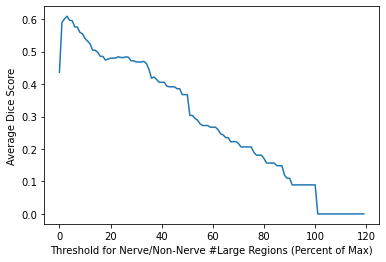

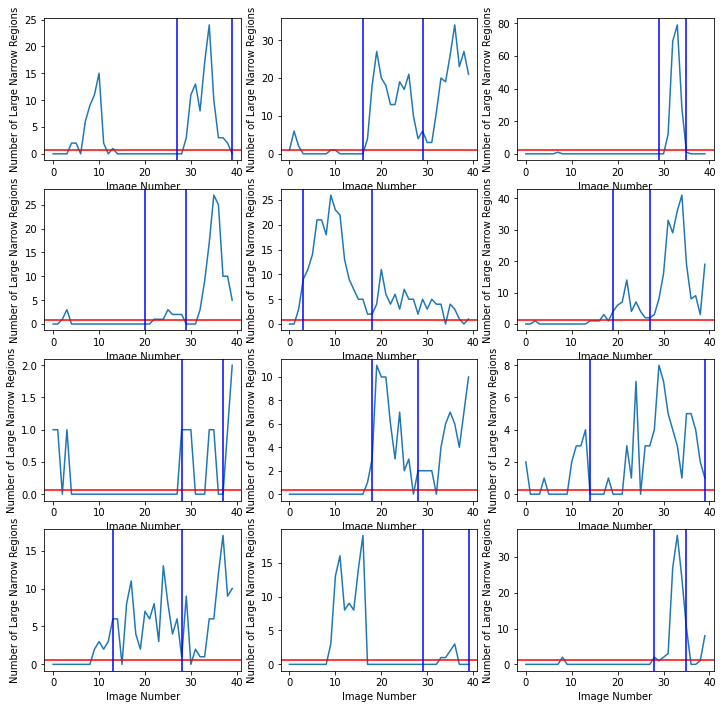

In [65]:
#Determine which patients will be in the training and test sets
#SEE COMMENTS FOR TIPS
i = 0; LNOCC_Training = {}; LNOCC_Test = {}
for key in LNOCC_12Patients.keys():
    i += 1
    if(i%13 != 0):                                       #TIP: Make it i%13 to make the training set have all 12 patients. Make it i%3 to make the training set have the first 2 patients in each disease category and the test set have the last 1
        print(i)
        LNOCC_Training[key] = LNOCC_12Patients[key]
    else:
        LNOCC_Test[key] = LNOCC_12Patients[key]

#Calculate the dice score
_, dec = findDiceAndDecThresh(LNOCC_Training)            #TIP: This uses the LNOCC_Training set to determine where the put the threshold for the cutoff of the percent of the max value for # of LNOCC
dice, theTPTPTNFN = calculateDice(LNOCC_Training, dec)   #TIP: Switch between LNOCC_Training and LNOCC_Test if you want to apply the parameters determined by the training set onto the test set or stick with the training set
print(dice, theTPTPTNFN)

#Display the connected component info for each patient
with PdfPages('scatterplotsNarrowLarge%sAnd%s-Conditions3.pdf' %(largeCutoff,narrowCutoff)) as pdf:
    fig = plt.figure(figsize=(12,12))
    patient = list(LNOCC_12Patients.keys());
    for pat in range(0,12):
        ax = fig.add_subplot(4,3,pat+1); 
        x = np.arange(0,40);
        y = LNOCC_12Patients[patient[pat]]; 
        ax.plot(x,y);
        nerveStart = whichImagesHaveNerves['First Nerve Image'].loc[pat]; 
        nerveEnd = whichImagesHaveNerves['Last Nerve Image'].loc[pat]; plt.xlabel('Image Number'); 
        plt.ylabel('Number of Large Narrow Regions'); 
        plt.axhline(y = dec*max(LNOCC_12Patients[patient[pat]]), color = 'r'); 
        plt.axvline(x = nerveStart, color = 'b'); plt.axvline(x = nerveEnd, color = 'b')
    pdf.savefig(fig)

### Main LNO (Test a range of parameters): Finds the Number of Large Narrow ConnectedComponents for Each Patients' Images

C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Canny Thresholds: 238, 246, Large Area Threshold: 12, Narrow Threshold 1.400000 Orient Threshold: 0.800000 0.5800890442583682


C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Canny Thresholds: 238, 246, Large Area Threshold: 13, Narrow Threshold 1.400000 Orient Threshold: 0.800000 0.5891973262653315


C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Canny Thresholds: 238, 246, Large Area Threshold: 14, Narrow Threshold 1.400000 Orient Threshold: 0.800000 0.5944140882917052


C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Canny Thresholds: 238, 246, Large Area Threshold: 15, Narrow Threshold 1.400000 Orient Threshold: 0.800000 0.6090928568110018


C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Canny Thresholds: 238, 246, Large Area Threshold: 16, Narrow Threshold 1.400000 Orient Threshold: 0.800000 0.6059668682844831


C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\dylan\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Canny Thresholds: 238, 246, Large Area Threshold: 17, Narrow Threshold 1.400000 Orient Threshold: 0.800000 0.5972701612414272


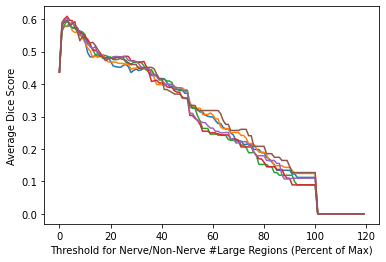

In [36]:
#I found the best lowThresh and upThresh for Canny edge detection to be 238, 246, but I didn't test every single combo, although I tested a lot. 
#Similarly, the best orient thresholds were around 0.79-0.9. The best was 0.79. The best large threshold was 15. 
#These were the best of the tested combinations and they may different with other combinations.
lowThresh = 238; upThresh = 246; root = r"Basal_Nerve_Density_Images"; x = []; y = []; z = [];

for largeCutoff in np.arange(start = 12, stop = 18, step = 1):
    for narrowCutoff in np.arange(start = 1.4, stop = 1.5, step= 1):
        for orientCutoff in np.arange(start = 0.75, stop = 0.9, step = 0.02):
            LNOCC_12Patients = {}; diceDictCLNO = {}
            ###FOR EACH PATIENT IN THE PATIENT LIST
            for subdir, dirs, imgs in os.walk(root):
                imagesInThisFolder = False; patientLargeNarrowCC = []
                ###FOR ALL IMAGES PER A PATIENT-X
                for img in imgs:           
                    imagesInThisFolder = True; ItIsAnImage = "count" not in img and 'jpg' in img
                    if(ItIsAnImage): 
                        image = processImageTest(cv2.imread(os.getcwd() + '\\' + subdir + '\\' + img, cv2.IMREAD_GRAYSCALE), lowThresh, upThresh)
                        try: patientLargeNarrowCC.append(largeNarrowOrientedCCCount(image, largeCutoff, narrowCutoff, orientCutoff));                           #Does blurring, morphological transforms, and Canny Edge
                        except: patientLargeNarrowCC.append(0)
                if(imagesInThisFolder == True): LNOCC_12Patients[subdir[27:]] = patientLargeNarrowCC
            dice = calculateDice(LNOCC_12Patients, findDiceAndDecThresh(LNOCC_12Patients))
            #x.append(largeCutoff); y.append(narrowCutoff); z.append(dice)
            diceDictCLNO['Canny Thresholds: %i, %i, Large Area Threshold: %i, Narrow Threshold %f, Orient Threshold: %f' %(lowThresh, upThresh, largeCutoff, narrowCutoff, orientCutoff)] = dice
            print('Canny Thresholds: %i, %i, Large Area Threshold: %i, Narrow Threshold %f Orient Threshold: %f' %(lowThresh, upThresh, largeCutoff, narrowCutoff, orientCutoff), dice)

In [27]:
with open('mainLNO.json','w') as j:
    json.dumps(diceDictCLNO, j)

NameError: name 'diceDictCLNO' is not defined

### Main LN (TEST): Finds the Number of Large Narrow ConnectedComponents for Each Patients' Images

Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 0.000000 0.5794738985286401
Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 0.150000 0.5794738985286401
Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 0.300000 0.5794738985286401
Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 0.450000 0.5794738985286401
Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 0.600000 0.5794738985286401
Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 0.750000 0.5794738985286401
Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 0.900000 0.5794738985286401
Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 1.050000 0.5794738985286401
Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 1.200000 0.5816663448841042
Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 1.350000 0.583853806338083
Canny Thresholds: 238

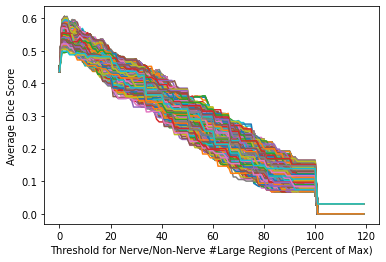

In [172]:
#I think this is the same as the above, except it does not use orientation
lowThresh = 238; upThresh = 246; root = r"Basal_Nerve_Density_Images"; diceDict = {};x = []; y = []; z = [];

for largeCutoff in np.arange(start = 0, stop = 30, step = 1):
    for narrowCutoff in np.arange(start = 0, stop = 4, step= 0.15):
        LNOCC_12Patients = {}
        ###FOR EACH PATIENT IN THE PATIENT LIST
        for subdir, dirs, imgs in os.walk(root):
            imagesInThisFolder = False; patientLargeNarrowCC = []
            ###FOR ALL IMAGES PER A PATIENT-X
            for img in imgs:           
                imagesInThisFolder = True; ItIsAnImage = "count" not in img and 'jpg' in img
                if(ItIsAnImage): 
                    image = processImageTest(cv2.imread(os.getcwd() + '\\' + subdir + '\\' + img, cv2.IMREAD_GRAYSCALE), lowThresh, upThresh)
                    try: patientLargeNarrowCC.append(LNOCC_12Patients(image, largeCutoff, narrowCutoff))                           #Does blurring, morphological transforms, and Canny Edge
                    except: patientLargeNarrowCC.append(0)
            if(imagesInThisFolder == True): LNOCC_12Patients[subdir[27:]] = patientLargeNarrowCC
        dice = calculateDice(LNOCC_12Patients, findDiceAndDecThresh(LNOCC_12Patients))
        x.append(largeCutoff); y.append(narrowCutoff); z.append(dice)
        diceDict['Canny Thresholds: %i, %i, Large Area Threshold: %i, Narrow Threshold %f' %(lowThresh, upThresh, largeCutoff, narrowCutoff)] = dice
        print('Canny Thresholds: %i, %i, Large Area Threshold: %i, Narrow Threshold %f' %(lowThresh, upThresh, largeCutoff, narrowCutoff), dice)

# Misc

In [202]:
len(diceDict)

810

In [180]:
dD = diceDict
with open('diceDictNarrow123.json','w') as j:
    json.dump(diceDict,j)

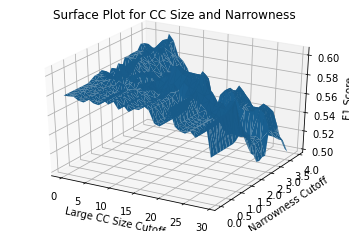

In [201]:
fig = plt.figure(); ax = plt.axes(projection = '3d'); ax.plot_trisurf(x,y,z);cmap = 'magma'; ax.set_title('Surface Plot for CC Size and Narrowness'); ax.set_xlabel('Large CC Size Cutoff'); ax.set_ylabel('Narrowness Cutoff'); ax.set_zlabel('F1 Score')
plt.show()

In [158]:
print(min(diceDict))
DO ORIENTATION AVERAGE DEVIATION
DO HEATMAP
Canny Thresholds: 238, 246, Large Area Threshold: 5, Narrow Threshold 3.500000 0.6005909133102115


Canny Thresholds: 238, 246, Large Area Threshold: 10, Narrow Threshold 0.500000


In [207]:
min(diceDict)

'Canny Thresholds: 238, 246, Large Area Threshold: 0, Narrow Threshold 0.000000'

In [17]:
my_dict = diceDictCLNO
key_max = max(my_dict.keys(), key=(lambda k: my_dict[k]))
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))

print('Maximum Value: ',my_dict[key_max])
print('Minimum Value: ',my_dict[key_min])

Maximum Value:  0.5986842311630262
Minimum Value:  0.5986842311630262


In [177]:
my_dict = diceDict
key_max = max(my_dict.keys(), key=(lambda k: my_dict[k]))
key_min = min(my_dict.keys(), key=(lambda k: my_dict[k]))

print('Maximum Value: ',my_dict[key_max])
print('Minimum Value: ',my_dict[key_min])


Maximum Value:  0.6056484105840595
Minimum Value:  0.4986275553750693


In [ ]:
dice = calculateDice(LNOCC_12Patients, findDiceAndDecThresh(LNOCC_12Patients))
print(dice)

with PdfPages('scatterplotsNarrowLarge%sAnd%s-Conditions3.pdf' %(largeCutoff,narrowCutoff)) as pdf:
    fig = plt.figure(figsize=(12,12))
    for pat in range(0,12):
        ax = fig.add_subplot(4,3,pat+1); patient = list(LNOCC_12Patients.keys());x = np.arange(0,40);y = LNOCC_12Patients[patient[pat]]; ax.plot(x,y);nerveStart = whichImagesHaveNerves['First Nerve Image'].loc[pat]; nerveEnd = whichImagesHaveNerves['Last Nerve Image'].loc[pat]; plt.xlabel('Image Number'); plt.ylabel('Number of Large Narrow Regions'); plt.axvline(x = nerveStart, color = 'b'); plt.axvline(x = nerveEnd, color = 'b')
    pdf.savefig(fig)

In [ ]:
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

dictOfAllKL = {}
for subdir in dictOfAllProperties.keys():
    dictOfAllKL[subdir] = {}
    KLList = []
    for img in dictOfAllProperties[subdir].keys():
        orientdist = []
        d = dictOfAllProperties['%s'%subdir]['%s\%s'%(subdir, img)]['orientation']
        for i in range(0,len(d):
            if(abs(d[i]) > 0.06):
                orientdist.append(d[i])
        uniformorientdist = np.full(1,mean(orientdist))
        KLList.append(KL(orientdist, uniformorientdist))
    dictOfAllKL[subdir] = KLList